!!! TO DO domani !!!
- scrivere come ho fatto a sistemare la gpu dal terminale (cf conversazione con claude)


Remarks
- Added initial cell to reload modules automatically 
- In `FormatData` definition
  - file paths are hardcoded -> either provide it as a fct parameter or mention in readme how names should be formatted
  - ~~the line `self.adata.obs = metadata_df` rewrites `self.adata.obs_names` as well!! --> I don't know if this should later be fixed?~~
- In readme
  - in `FormatData` documentation, `.x_train` and `.x_test` are said to be DataFrames but I think they're arrays
  - `.selected_genes` are explained twice (and are the same info as `.genes`)
  - in `binary_pso` documentation, `current_data` is said to be a dataframe, but I think it is a `FormatData` object
- PredAnnModel didn't use to scale data??? <- check this!! TODO
- !!! I think results aren't deterministic/reproducible!

# Single Cell Walkthrough

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
from PAGEpy import plot_functions
from PAGEpy import pso as pso
from PAGEpy.dataset_class import GeneExpressionDataset
from PAGEpy.models import AdvancedNN, SimpleNN, TrainingConfig
import pickle
import pandas as pd
from PAGEpy import PAGEpy_utils

# memory growth is enabled for for the gpu
gpu_available = PAGEpy_utils.init_cuda()

19:22:46 [PAGEpy_utils:15] Memory growth enabled for 1 GPU(s)
19:22:46 [PAGEpy_utils:20] GPU devices available: 1


## Create Dataset
Dataset has 2000 gene features, selected using `HVG` (can also use differential expression analysis `Diff`; leave empty to use whole gene list given by `genes_pattern`).

In [3]:
n_hvg_input_features = 2000

# TODO: instead of file patterns, use whole filenames
current_data = GeneExpressionDataset(
    data_dir="../../HIVdata/",
    counts_pattern="*counts.mtx",
    barcodes_pattern="*barcodes.txt",
    # I think here it's possible to set already processed gene list:
    genes_pattern="*genes.txt",
    metadata_pattern="*infection_status.csv",
    gene_selection="HVG",
    pval_correction="benjamini-hochberg",
    hvg_count=n_hvg_input_features,
    features_out_filename="feature_set.pkl",
    train_samples_out_filename="train_samples.txt",
    # positive_label="Infected"
)

19:22:46 [dataset_class:133] AnnData object constructed with 5261 samples and 18116 features (genes).
19:22:46 [dataset_class:140] Counts normalized and log-transformed.
19:22:46 [dataset_class:192] Split data: 4208 training samples, 1053 test samples.
19:22:47 [dataset_class:246] Selected 2000 features using HVG


In [4]:
# the selected genes can be loaded from the local directory, however, they are
# also an attribte of the GeneExpressionDataset object
genes_path = "feature_set.pkl"

with open(genes_path, "rb") as f:
    current_genes = pickle.load(f)
print(f"Loaded {len(current_genes)} genes as 'current_genes'")

Loaded 2000 genes as 'current_genes'


## Initialize and train NN Model

Set NN model parameters

In [ ]:
# retrieved default params used in Sean's code
config = TrainingConfig(
    report_frequency=1,
    auc_threshold=1,
    learning_rate=0.001)

training_params = {
    # 'n_epochs': 50,
    'n_epochs': 500,
    'batch_size': 64,
    'seed': 42,
}

Train NN model before PSO

In [6]:
# Initialize NN model
initial_model = AdvancedNN(
    # initial_model = SimpleNN(
    n_input_features=n_hvg_input_features,
    config=config,
)

# Train model
train_history = initial_model.train(
    x_train=current_data.x_train,
    y_train=current_data.y_train,
    x_test=current_data.x_test,
    y_test=current_data.y_test,
    **training_params,
)

n_samples_per_epoch 2104
batch_size 64
n_steps_per_epoch 32


19:22:49 [models:391] Epoch 0: Adjusting learning rate to 0.005000
19:22:54 [models:508] Epoch 10/500:
	Train Loss: 0.1630, AUC: 0.9905, Acc: 0.9482
	Test AUC: 0.9500, Acc: 0.8794
19:22:59 [models:508] Epoch 20/500:
	Train Loss: 0.0482, AUC: 0.9983, Acc: 0.9791
	Test AUC: 0.9319, Acc: 0.8528
19:23:03 [models:508] Epoch 30/500:
	Train Loss: 0.0251, AUC: 0.9999, Acc: 0.9929
	Test AUC: 0.9347, Acc: 0.8481
19:23:08 [models:508] Epoch 40/500:
	Train Loss: 0.0154, AUC: 0.9999, Acc: 0.9933
	Test AUC: 0.9190, Acc: 0.8462
19:23:13 [models:508] Epoch 50/500:
	Train Loss: 0.0120, AUC: 1.0000, Acc: 0.9957
	Test AUC: 0.9177, Acc: 0.8443
19:23:18 [models:508] Epoch 60/500:
	Train Loss: 0.0065, AUC: 1.0000, Acc: 0.9955
	Test AUC: 0.9219, Acc: 0.8519
19:23:23 [models:508] Epoch 70/500:
	Train Loss: 0.0184, AUC: 1.0000, Acc: 0.9952
	Test AUC: 0.9144, Acc: 0.8557
19:23:28 [models:508] Epoch 80/500:
	Train Loss: 0.0121, AUC: 1.0000, Acc: 0.9919
	Test AUC: 0.9215, Acc: 0.8557
19:23:33 [models:508] Epoch 9

19:26:50 [plot_functions:29] Max metrics
	Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.88 | Test AUC: 0.95


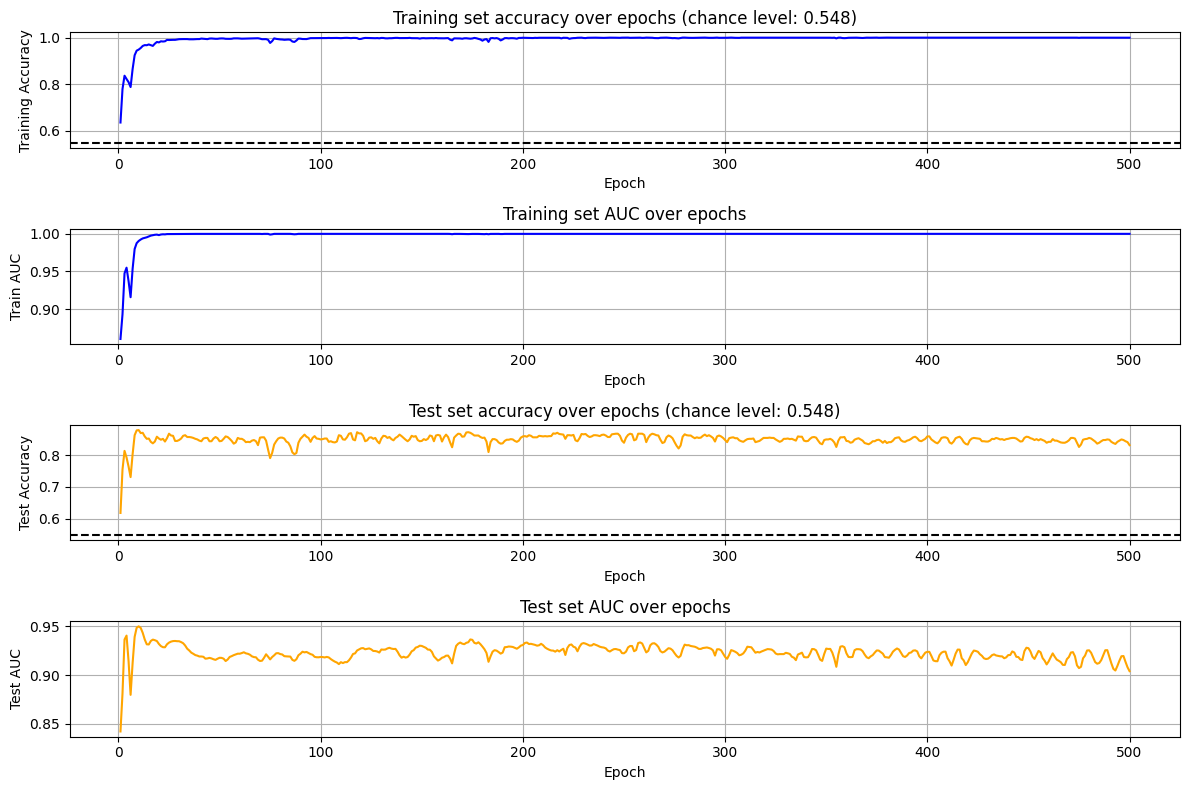

In [7]:
plot_functions.plot_model_history(
    model_history=train_history,
    report_frequency=initial_model.config.report_frequency,
    y_train=current_data.y_train,
    y_test=current_data.y_test,
    save_path=None
)

## Run binary PSO

TO DO: is the algorithm leveraging the GPU??

In [8]:
# the pso algorithm can be use to optimze the solution
best_solution, best_fitness = pso.run_binary_pso(
    input_data=current_data,
    feature_names=current_genes,
    # pop_size=200,
    pop_size=5,
    # n_generations=15,
    n_generations=2,
    w=1,
    c1=2,
    c2=1.5,
    # n_reps=4,
    n_reps=1,
    verbose=True,
    # verbose=False,
    adaptive_metrics=False
)

11:51:21 [pso:204] ============================================================
11:51:21 [pso:205] Generation 1 started
11:51:39 [fitness_functions:134] Particle 1: Genes=1040 | Mean AUC=0.646 | Time=17.75s
11:51:56 [fitness_functions:134] Particle 2: Genes=991 | Mean AUC=0.578 | Time=17.51s
11:52:14 [fitness_functions:134] Particle 3: Genes=1043 | Mean AUC=0.600 | Time=17.85s
11:52:32 [fitness_functions:134] Particle 4: Genes=1019 | Mean AUC=0.682 | Time=17.88s
11:52:50 [fitness_functions:134] Particle 5: Genes=1040 | Mean AUC=0.586 | Time=18.12s
11:52:50 [pso:247] Generation 1 summary: Best AUC: 0.6825 | Average AUC: 0.6183 | Duration: 89.21s
11:52:50 [pso:204] ============================================================
11:52:50 [pso:205] Generation 2 started
11:53:08 [fitness_functions:134] Particle 1: Genes=1002 | Mean AUC=0.661 | Time=18.20s
11:53:26 [fitness_functions:134] Particle 2: Genes=995 | Mean AUC=0.665 | Time=17.75s
11:53:44 [fitness_functions:134] Particle 3: Genes=103

In [9]:
# the results of pso optimizatoin can be monitored
loaded_fitness_scores = pd.read_pickle("pso_fitness_scores.pkl")
loaded_particle_history = pd.read_pickle("pso_particle_history.pkl")

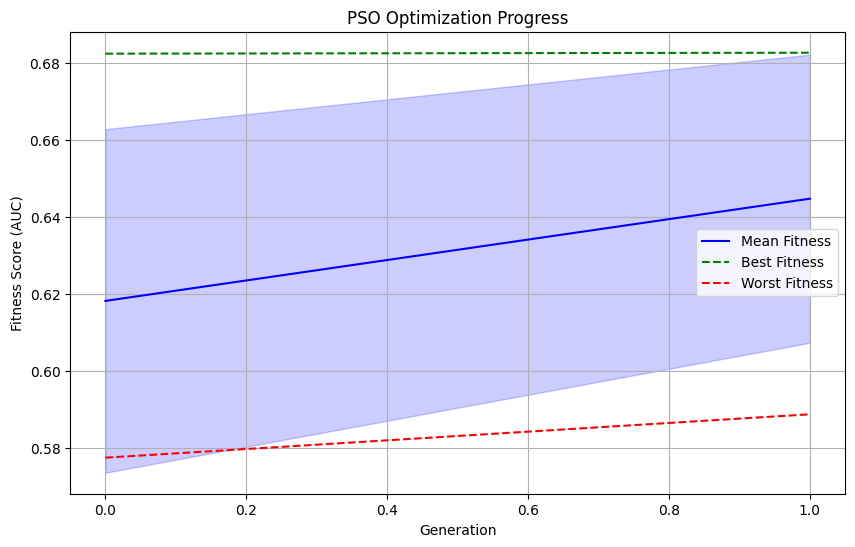

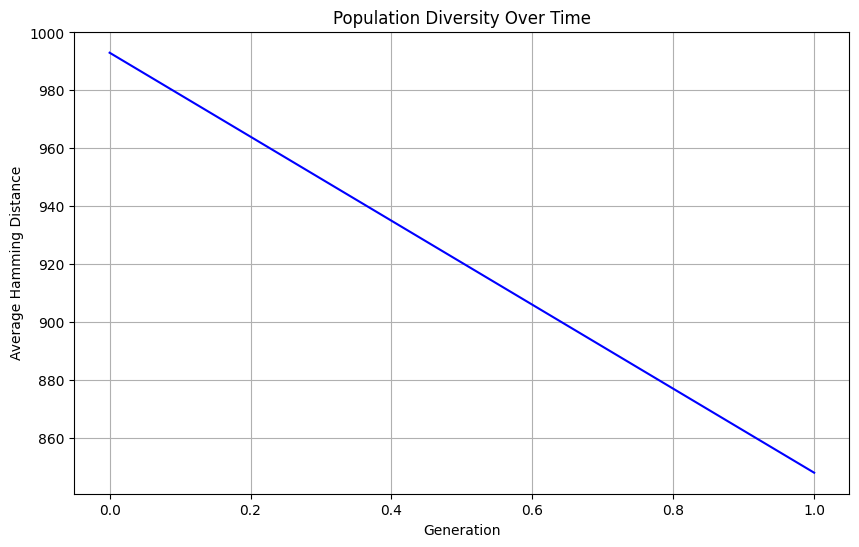

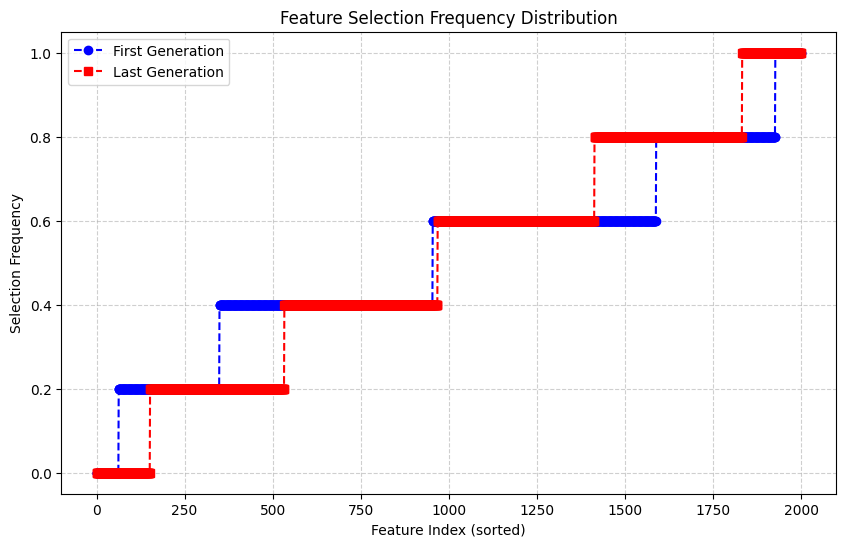

In [10]:
plot_functions.plot_pso_fitness_evolution(loaded_fitness_scores)
plot_functions.plot_population_diversity(loaded_particle_history)
plot_functions.plot_feature_selection_frequency(
    loaded_particle_history)

## Initialize and train improved NN Model

In [ ]:
# the optimised solution is saved locally, however, the returned varible from
# the binary_pso function can also be passed to the model (see below)
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open("pso_selected_genes.pkl", "rb") as f:
    pso_genes = pickle.load(f)

In [12]:
# now use this gene list to train a new model, which you can then evaluate
n_pso_input_features = len(pso_genes)

improved_model = AdvancedNN(
    # improved_model = SimpleNN(
    n_input_features=n_pso_input_features,
    config=config,
)

# select feature subset and scale data
x_train, x_test, y_train, y_test = current_data.get_scaled_feature_subset(
    feature_subset=pso_genes
)

# Train model
improved_train_history = improved_model.train(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    **training_params,
)

11:54:24 [models:389] Epoch 0: Adjusting learning rate to 0.005000
11:54:28 [models:503] Epoch 10/50:
	Train Loss: 0.1972, AUC: 0.9777, Acc: 0.9064
	Test AUC: 0.9227, Acc: 0.8367
11:54:33 [models:503] Epoch 20/50:
	Train Loss: 0.0810, AUC: 0.9955, Acc: 0.9734
	Test AUC: 0.9227, Acc: 0.8433
11:54:37 [models:503] Epoch 30/50:
	Train Loss: 0.0289, AUC: 0.9997, Acc: 0.9898
	Test AUC: 0.9010, Acc: 0.8357
11:54:42 [models:503] Epoch 40/50:
	Train Loss: 0.0228, AUC: 0.9999, Acc: 0.9917
	Test AUC: 0.9139, Acc: 0.8329
11:54:46 [models:503] Epoch 50/50:
	Train Loss: 0.0132, AUC: 0.9999, Acc: 0.9938
	Test AUC: 0.9060, Acc: 0.8272


11:54:46 [plot_functions:29] Max metrics
Train Accuracy: 1.00 | Train AUC: 1.00 | Test Accuracy: 0.86 | Test AUC: 0.93


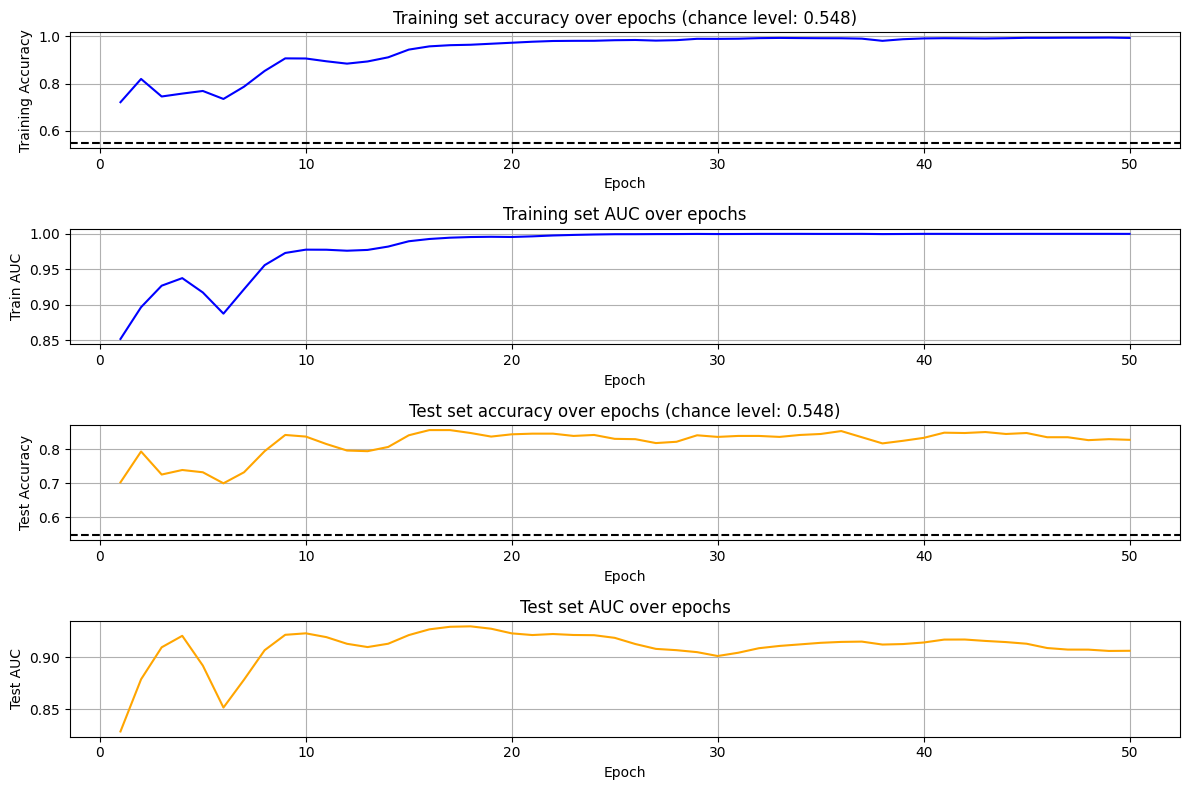

In [13]:
plot_functions.plot_model_history(
    model_history=improved_train_history,
    report_frequency=improved_model.config.report_frequency,
    y_train=y_train,
    y_test=y_test,
    save_path=None
)